# Quantum Circuits and Quantum Tasks in Amazon Braket

In this tutorial we discuss in detail the anatomy of quantum circuits in Amazon Braket's SDK. Specifically, we learn how to build (parametrized) circuits and display them graphically, how to append circuits to each other, and discuss the associated circuit depth and circuit size. Finally we show how to execute our circuit on a device of our choice (defining a quantum task). We then learn how to efficiently track, log, recover or cancel such a _quantum task_. 

In [50]:
import asyncio
import logging
import string
from datetime import datetime
from time import sleep

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from braket.aws import AwsDevice, AwsQuantumTask
from braket.circuits import Circuit, Gate, Instruction, circuit, Observable
from braket.devices import LocalSimulator

# Circuit Definition

Let us get started a sample circuit for four qubits (labelled q0, q1, q2 and q3) consisting of standard single-qubit ```Hadamard``` gates and two-qubit ```CNOT``` gates; for a full list of available gates see below. We can then visualize our circuit by simply calling the ```print``` function. 

In [51]:
# define circuit with 4 qubits
my_circuit = Circuit().h(range(4)).cnot(control=0, target=2).cnot(control=1, target=3)
print(my_circuit)


T  : |0| 1 |
            
q0 : -H-C---
        |   
q1 : -H-|-C-
        | | 
q2 : -H-X-|-
          | 
q3 : -H---X-

T  : |0| 1 |


## Moments and Instructions

Here, time is sliced up into **moments**. The circuit above consists of just two moments. First, we apply a ```Hadamard``` gate to every qubit in moment 0 and then we apply two ```CNOT``` gates. Since the latter can be run in parallel as they involve different sets of qubits, they only use up one moment of time. For better readability they are displayed next to each other with some small offset. 

In [52]:
# show moments of our quantum circuit
moments = my_circuit.moments
for moment in moments:
    print(moment)


MomentsKey(time=0, qubits=QubitSet([Qubit(0)]), moment_type=<MomentType.GATE: 'gate'>, noise_index=0)
MomentsKey(time=0, qubits=QubitSet([Qubit(1)]), moment_type=<MomentType.GATE: 'gate'>, noise_index=0)
MomentsKey(time=0, qubits=QubitSet([Qubit(2)]), moment_type=<MomentType.GATE: 'gate'>, noise_index=0)
MomentsKey(time=0, qubits=QubitSet([Qubit(3)]), moment_type=<MomentType.GATE: 'gate'>, noise_index=0)
MomentsKey(time=1, qubits=QubitSet([Qubit(0), Qubit(2)]), moment_type=<MomentType.GATE: 'gate'>, noise_index=0)
MomentsKey(time=1, qubits=QubitSet([Qubit(1), Qubit(3)]), moment_type=<MomentType.GATE: 'gate'>, noise_index=0)


In [53]:
# list all instructions/gates making up our circuit
instructions = my_circuit.instructions
for instruction in instructions:
    print(instruction)

Instruction('operator': H('qubit_count': 1), 'target': QubitSet([Qubit(0)]))
Instruction('operator': H('qubit_count': 1), 'target': QubitSet([Qubit(1)]))
Instruction('operator': H('qubit_count': 1), 'target': QubitSet([Qubit(2)]))
Instruction('operator': H('qubit_count': 1), 'target': QubitSet([Qubit(3)]))
Instruction('operator': CNot('qubit_count': 2), 'target': QubitSet([Qubit(0), Qubit(2)]))
Instruction('operator': CNot('qubit_count': 2), 'target': QubitSet([Qubit(1), Qubit(3)]))


## Custom Gates

Next, let us build a **parametrized circuit** where we have to supply numerical parameter values to fully define the circuit, as is the case for example for single-qubit rotations (as described [here](https://github.com/aws/amazon-braket-sdk-python/blob/main/src/braket/circuits/gates.py#L578)) and the two-qubit ```cnot``` as described in the source code [here](https://github.com/aws/amazon-braket-sdk-python/blob/main/src/braket/circuits/gates.py#L701). The specific parameter values are shown in circuit diagram. 

In [54]:
# define circuit with some parametrized gates
my_circuit = (
    Circuit()
    .rx(0, 0.15)
    .ry(1, 0.2)
    .rz(2, 0.25)
    .h(3)
    .cnot(control=0, target=2)
    .cnot(1, 3)
    .x([1, 3])
)
print(my_circuit)


T  : |   0    | 1 |2|
                     
q0 : -Rx(0.15)-C-----
               |     
q1 : -Ry(0.20)-|-C-X-
               | |   
q2 : -Rz(0.25)-X-|---
                 |   
q3 : -H----------X-X-

T  : |   0    | 1 |2|


__Gate set__: Below we list all gates currently available in our SDK. Moreover, we can build custom gates as shown below for a general single-qubit rotation. 

In [55]:
# print all available gates currently available within SDK
gate_set = [attr for attr in dir(Gate) if attr[0] in string.ascii_uppercase]
print(gate_set)


['CCNot', 'CNot', 'CPhaseShift', 'CPhaseShift00', 'CPhaseShift01', 'CPhaseShift10', 'CSwap', 'CV', 'CY', 'CZ', 'ECR', 'H', 'I', 'ISwap', 'PSwap', 'PhaseShift', 'Rx', 'Ry', 'Rz', 'S', 'Si', 'Swap', 'T', 'Ti', 'Unitary', 'V', 'Vi', 'X', 'XX', 'XY', 'Y', 'YY', 'Z', 'ZZ']


In [56]:
# helper function to build custom gate
def calc_u3_matrix(alpha, theta, phi):
    """
    function to return matrix for general single qubit rotation
    rotation is given by exp(-i sigma*n/2*alpha) where alpha is rotation angle
    and n defines rotation axis as n=(sin(theta)cos(phi), sin(theta)sin(phi), cos(theta))
    sigma is vector of Pauli matrices
    """
    u11 = np.cos(alpha / 2) - 1j * np.sin(alpha / 2) * np.cos(theta)
    u12 = -1j * (np.exp(-1j * phi)) * np.sin(theta) * np.sin(alpha / 2)
    u21 = -1j * (np.exp(1j * phi)) * np.sin(theta) * np.sin(alpha / 2)
    u22 = np.cos(alpha / 2) + 1j * np.sin(alpha / 2) * np.cos(theta)

    return np.array([[u11, u12], [u21, u22]])


In [57]:
# define a custom unitary
my_u3 = calc_u3_matrix(np.pi / 2, 0, 0)

# define example circuit applying custom U to the first qubit
my_circuit = Circuit().unitary(matrix=my_u3, targets=[0]).h(1).cnot(control=0, target=1)
print(my_circuit)


T  : |0|1|
          
q0 : -U-C-
        | 
q1 : -H-X-

T  : |0|1|


Here, in the circuit diagram our custom unitary is depicted with the general symbol ```U```. 
In addition, we can use Braket's `circuit.subroutine` functionality, which allows us to use custom-built gates as any other built-in gates.  

In [58]:
# helper function to build custom gate
@circuit.subroutine(register=True)
def u3(target, angles):
    """
    Function to return the matrix for a general single qubit rotation,
    given by exp(-i sigma*n/2*alpha), where alpha is the rotation angle,
    n defines the rotation axis via n=(sin(theta)cos(phi), sin(theta)sin(phi), cos(theta)),
    and sigma is the vector of Pauli matrices
    """
    matrix = calc_u3_matrix(*angles)

    # define custom Braket gate
    circ = Circuit()
    circ.unitary(matrix=matrix, targets=target)

    return circ


In [59]:
# define example circuit applying custom single-qubit gate U to the first qubit
angles = [np.pi/2, np.pi/2, np.pi/2]
angles = [np.pi/4, 0, 0]

# build circuit using custom u3 gate
circ = Circuit().u3([0], angles).cnot(control=0, target=1)
print(circ)

T  : |0|1|
          
q0 : -U-C-
        | 
q1 : ---X-

T  : |0|1|


## Circuit Depth and Size

We can get the **circuit depth** (the number of moments defining our circuit) with ```circuit.depth``` as shown below. 

In [60]:
# define circuit with parametrized gates
my_circuit = (
    Circuit()
    .rx(0, 0.15)
    .ry(1, 0.2)
    .rz(2, 0.25)
    .h(3)
    .cnot(control=0, target=2)
    .cnot(1, 3)
    .x(0)
)

circuit_depth = my_circuit.depth
print(my_circuit)
print()
print(f"{circuit_depth = }")


T  : |   0    | 1 |2|
                     
q0 : -Rx(0.15)-C---X-
               |     
q1 : -Ry(0.20)-|-C---
               | |   
q2 : -Rz(0.25)-X-|---
                 |   
q3 : -H----------X---

T  : |   0    | 1 |2|

circuit_depth = 3


The total circuit depth of the circuit above is three (moments 0, 1, 2). It is three because we have added a single qubit ```X``` gate applied to qubit 0 in the final layer. However, note that gates are applied as early as possible in time, provided that this is not in conflict with any other gate that has to be applied before.

See below an example where we add one qubit to which we only apply one single qubit ```X``` gate. This circuit is shallower as its circuit depth is only two. The ```X``` gate is applied to qubit 4 as early as possible even though we have applied the corresponding command at the end of our circuit definition. 

In [61]:
my_circuit = (
    Circuit()
    .rx(0, 0.15)
    .ry(1, 0.2)
    .rz(2, 0.25)
    .h(3)
    .cnot(control=0, target=2)
    .cnot(1, 3)
    .x(4)
)

circuit_depth = my_circuit.depth
qubit_count = my_circuit.qubit_count

# get approx. estimate of circuit size
circuit_size = circuit_depth * qubit_count


print(my_circuit)
print()

print(f"{circuit_depth = }")
print(f"{qubit_count = }")
print(f"{circuit_size = }")


T  : |   0    | 1 |
                   
q0 : -Rx(0.15)-C---
               |   
q1 : -Ry(0.20)-|-C-
               | | 
q2 : -Rz(0.25)-X-|-
                 | 
q3 : -H----------X-
                   
q4 : -X------------

T  : |   0    | 1 |

circuit_depth = 2
qubit_count = 5
circuit_size = 10


In the example above we have also introduced the concept of __circuit size__. Intuitively, the circuit size is a metric that reflects the complexity of our circuit. The circuit size accounts for both quantity (the number of qubits) and quality (as captured by the depth of the circuit); here we have used a very simple definition multiplying the qubit number with the circuit depth (that is the area of our diagram).

In practice, in the absence of quantum error correction, on real quantum machines the depth is limited by noise so we can only faithfully run circuits whose depth is within the quality bounds of our machine. Simply speaking, this means: The larger the circuit size, the harder it is to simulate on a classical device and the more powerful the quantum machine is that is able to faithfully execute this circuit. 

## Appending circuits

We can extend existing circuits by adding instructions or just appending circuits to each other, as shown below. In the most simple and straightforward fashion we can just append gates to existing circuits (for example, ```my_circuit.y(4)```). 

In [62]:
# simple circuit extension by appending gates (here Y on qubit 4)
my_circuit = my_circuit.y(4)

circuit_depth = my_circuit.depth
qubit_count = my_circuit.qubit_count
circuit_size = circuit_depth * qubit_count

print(my_circuit)
print()

print(f"{circuit_depth = }")
print(f"{qubit_count = }")
print(f"{circuit_size = }")


T  : |   0    | 1 |
                   
q0 : -Rx(0.15)-C---
               |   
q1 : -Ry(0.20)-|-C-
               | | 
q2 : -Rz(0.25)-X-|-
                 | 
q3 : -H----------X-
                   
q4 : -X--------Y---

T  : |   0    | 1 |

circuit_depth = 2
qubit_count = 5
circuit_size = 10


Alternatively, we can define a gate as an ```Instruction``` and use the ```add_instruction(...)``` method to add this gate to an existing circuit object.

In [63]:
# add instruction to circuit
gate_instr = Instruction(Gate.CNot(), [0, 1])
my_circuit = my_circuit.add_instruction(gate_instr)

circuit_depth = my_circuit.depth
qubit_count = my_circuit.qubit_count
circuit_size = circuit_depth * qubit_count

print(my_circuit)
print()

print(f"{circuit_depth = }")
print(f"{qubit_count = }")
print(f"{circuit_size = }")

T  : |   0    | 1 |2|
                     
q0 : -Rx(0.15)-C---C-
               |   | 
q1 : -Ry(0.20)-|-C-X-
               | |   
q2 : -Rz(0.25)-X-|---
                 |   
q3 : -H----------X---
                     
q4 : -X--------Y-----

T  : |   0    | 1 |2|

circuit_depth = 3
qubit_count = 5
circuit_size = 15


We can append entire circuits to each other with ```add_circuit()```. 

In [64]:
# append two circuits with add_circuit() functionality
my_circuit2 = Circuit().rz(0, 0.1).rz(1, 0.2).rz(3, 0.3).rz(4, 0.4)
my_circuit.add_circuit(my_circuit2)

circuit_depth = my_circuit.depth
qubit_count = my_circuit.qubit_count
circuit_size = circuit_depth * qubit_count

print(my_circuit)
print()

print(f"{circuit_depth = }")
print(f"{qubit_count = }")
print(f"{circuit_size = }")

T  : |   0    | 1 |   2    |   3    |
                                     
q0 : -Rx(0.15)-C---C--------Rz(0.10)-
               |   |                 
q1 : -Ry(0.20)-|-C-X--------Rz(0.20)-
               | |                   
q2 : -Rz(0.25)-X-|-------------------
                 |                   
q3 : -H----------X-Rz(0.30)----------
                                     
q4 : -X--------Y---Rz(0.40)----------

T  : |   0    | 1 |   2    |   3    |

circuit_depth = 4
qubit_count = 5
circuit_size = 20


Again, note that the single qubit rotations we have appended to our circuit are applied as early as possible. This helps keeping the circuit as short as possible, as required in the presence of decoherence.  

# Circuit execution and Task tracking

Finally, let us run our circuit on a device of our choice. We do so by defining a classical ```device``` object below and calling the method ```device.run(my_circuit)```. Additional _task creation_ arguments can be provided to the ```run()``` method of the device object; in particular the optional “shots” argument refers to the number of desired measurement shots (default = 1000).

The command ```device.run(...)``` defines a task (with a unique task ID), the status of which can be queried and tracked with ```task.state()``` as shown below. Once the task completes (which may take some time, specifically for the QPU devices, depending on the length of the queue), one can retrieve the results from the S3 bucket as specified below; you can check for "Task Status” under Tasks within your Braket console. Note that ```task = device.run()``` is an _asynchronous_ operation. This means you can keep working while the system in the background polls for the results. You can always check the task status with ```task.state()```. When you call ```task.result()```, this becomes a blocking call that will throw an error if within the timeout period you will not get a result. We show below how to set this timeout period. 

By calling ```result()``` on a task, you get the quantum task result by polling Amazon Braket to see if the task is completed. Once the task is completed, the result is retrieved from S3 and returned as a ```QuantumTaskResult```. As opposed to ```async_result()```, this method is a blocking thread call and synchronously returns a result.

In [65]:
device = AwsDevice("arn:aws:braket:::device/quantum-simulator/amazon/sv1")

We can check out the set of gates this device supports as follows: 

In [66]:
# supportedQuantumOperations (supported gates for a device)
device_operations = device.properties.dict()["action"]["braket.ir.jaqcd.program"][
    "supportedOperations"
]

# Note: This field also exists for other devices like the QPUs
print("Quantum Gates supported by this device:\n", device_operations)


Quantum Gates supported by this device:
 ['ccnot', 'cnot', 'cphaseshift', 'cphaseshift00', 'cphaseshift01', 'cphaseshift10', 'cswap', 'cy', 'cz', 'ecr', 'h', 'i', 'iswap', 'pswap', 'phaseshift', 'rx', 'ry', 'rz', 's', 'si', 'swap', 't', 'ti', 'unitary', 'v', 'vi', 'x', 'xx', 'xy', 'y', 'yy', 'z', 'zz']


__Polling parameters__: With the ```run(...)``` method we can set two important parameters: 
* ```poll_timeout_seconds``` is the number of seconds you want to wait and poll the task before it times out; the default value is 5 days (that is $\sim 5*60*60*24$ seconds). 
* ```poll_interval_seconds``` is the frequency how often the task is polled, e.g., how often you call the Braket API to get the status; the default value is 1 second. 

task_id = 'arn:aws:braket:us-east-1:901160528933:quantum-task/4ef310d0-1da3-4f8d-b18a-0eb3e2c16efd'
status = 'CREATED'
status = 'COMPLETED'
Counter({'00000': 493, '00010': 486, '11110': 9, '11100': 5, '01000': 5, '01010': 2})


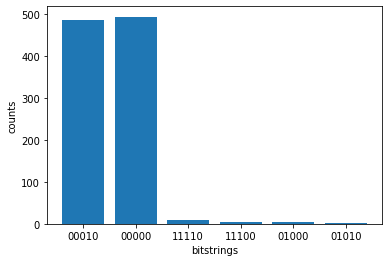

In [67]:
# define task (asynchronous)
task = device.run(my_circuit, poll_timeout_seconds=100, shots=1000)

task_id = task.id
status = task.state()

print(f"{task_id = }")
print(f"{status = }")

# wait for job to complete
while status != "COMPLETED":
    sleep(2)
    status = task.state()

print(f"{status = }")


result = task.result()

# get measurement shots
counts = result.measurement_counts
print(counts)

plt.bar(counts.keys(), counts.values())
plt.xlabel("bitstrings")
plt.ylabel("counts");


__Task metadata__: You can access a range of metadata associated with your ```task``` object:

In [68]:
# get all metadata of submitted task
metadata = task.metadata()

shots = metadata["shots"]
date = metadata["ResponseMetadata"]["HTTPHeaders"]["date"]
print(f"{shots} shots taken on {date}.")


1000 shots taken on Wed, 27 Jul 2022 18:55:16 GMT.


__Task reconstruction__: Imagine your kernel dies after you have submitted the task, or you simply close your notebook. As recovery method, here is how you can reconstruct the ```task``` object (given the corresponding unique arn). You can reconstruct the ```task``` object using `task = AwsQuantumTask(arn=...)`; then you can simply call `task.result()` to get the result from S3. 

In [69]:
# restore task from unique arn
task_load = AwsQuantumTask(arn=task_id)

status = task_load.state()
print("Status of (reconstructed) task:", status)


Status of (reconstructed) task: COMPLETED


In [70]:
# get results of task
result = task_load.result()

# get measurement shots
counts = result.measurement_counts
print(counts)

Counter({'00000': 493, '00010': 486, '11110': 9, '11100': 5, '01000': 5, '01010': 2})


__Task cancellation__: Finally, we can also cancel existing tasks by calling the ```cancel()``` method.

In [71]:
task = device.run(my_circuit, shots=1000)

task_id = task.id
status = task.state()

print(f"{task_id = }")
print(f"{status = }")

# cancel task
task.cancel()
status = task.state()
print(f"{status = }")

sleep(20)
status = task.state()
print(f"{status = }")


task_id = 'arn:aws:braket:us-east-1:901160528933:quantum-task/0f1cb7e6-69d1-4a91-8b35-7c402f579651'
status = 'CREATED'
status = 'QUEUED'
status = 'COMPLETED'


# Result Types: Expectation Values and Observables 

So far, we have only taken measurements in the computational basis. However, it is also possible to measure in other bases, as well as estimate important statistics like expectation value and variance. We do this by adding `ResultType`s to our circuit; in the following example, we will make measurements in the basis of the observable $X_{0}Y_{1}$ (this is the tensor product $X(0) \otimes Y(1)$):

In [72]:
my_circuit = (
    Circuit()
    .rx(0, 0.15)
    .ry(1, 0.2)
    .rz(2, 0.25)
    .h(3)
    .cnot(control=0, target=2)
    .cnot(1, 3)
    .x(4)
)

target_qubits = [0, 1]

# add expectation value
obs = Observable.X() @ Observable.Y()
my_circuit.expectation(obs, target=target_qubits)

# add variance
my_circuit.variance(obs, target=target_qubits)

# add samples
my_circuit.sample(obs, target=target_qubits)

print(my_circuit)


T  : |   0    | 1 |               Result Types               |
                                                              
q0 : -Rx(0.15)-C---Expectation(X@Y)-Variance(X@Y)-Sample(X@Y)-
               |   |                |             |           
q1 : -Ry(0.20)-|-C-Expectation(X@Y)-Variance(X@Y)-Sample(X@Y)-
               | |                                            
q2 : -Rz(0.25)-X-|--------------------------------------------
                 |                                            
q3 : -H----------X--------------------------------------------
                                                              
q4 : -X-------------------------------------------------------

T  : |   0    | 1 |               Result Types               |


_Note_: `sample` is only valid when `shots > 0`.

As shown above, results types are part of the `print` information. We now run this circuit on the local simulator above and output these results. 

In [73]:
device = LocalSimulator()

task = device.run(my_circuit, shots=100)
result = task.result()

print("Expectation value for <X0*Y1>:", result.values[0])
print("Variance for <X0*Y1>:", result.values[1])
print("Measurement samples for X0*Y1:", result.values[2])

Expectation value for <X0*Y1>: -0.06
Variance for <X0*Y1>: 0.9963999999999997
Measurement samples for X0*Y1: [ 1. -1. -1.  1. -1.  1. -1. -1. -1. -1.  1.  1. -1. -1.  1. -1. -1.  1.
  1. -1. -1.  1. -1. -1. -1.  1.  1.  1.  1.  1.  1. -1. -1. -1.  1. -1.
  1.  1.  1. -1.  1.  1. -1. -1.  1. -1. -1. -1.  1. -1. -1. -1.  1. -1.
 -1. -1.  1. -1. -1.  1. -1. -1.  1. -1. -1.  1. -1.  1.  1. -1. -1.  1.
  1. -1.  1. -1.  1. -1. -1.  1.  1. -1.  1.  1.  1. -1. -1.  1.  1.  1.
  1.  1. -1. -1.  1.  1. -1.  1. -1. -1.]


We can verify that we get the same estimate for the expectation value if we compute it by hand from the samples:

In [74]:
samples = result.values[2]

sum_of_samples = samples.sum()
total_counts = len(samples)
expect_from_samples = sum_of_samples / total_counts

print("Expectation value from samples:", expect_from_samples)


Expectation value from samples: -0.06


So far, we have measured only one observable, namely $X_{0}Y_{1}$. However, it is possible to measure multiple observables at once, provided that any observables with overlapping qubits have the same factor acting on each qubit:

In [75]:
circ = (
    Circuit()
    .rx(0, 0.15)
    .ry(1, 0.2)
    .rz(2, 0.25)
    .h(3)
    .cnot(control=0, target=2)
    .cnot(1, 3)
    .x(4)
)
circ.expectation(Observable.X() @ Observable.Y(), target=[0, 1])
circ.expectation(Observable.Z() @ Observable.H(), target=[2, 4])

# Overlaps on qubits 1 and 4, but Y and H are the same factors that have been applied to each, respectively
circ.expectation(Observable.Y() @ Observable.X() @ Observable.H(), target=[1, 3, 4])

task = device.run(circ, shots=1000)
result = task.result()
print("Expectation value for <X0*Y1>:", result.values[0])
print("Expectation value for <Z2*H4>:", result.values[1])
print("Expectation value for <Y1*X3*H4>::", result.values[2])


Expectation value for <X0*Y1>: -0.004
Expectation value for <Z2*H4>: -0.674
Expectation value for <Y1*X3*H4>:: 0.0


This is possible because we only need to measure in at most one basis for each qubit. For instance in the example above, on qubit 1 we only measure in the Y basis.

## Result Types for `shots = 0`

In all examples discussed so far we have set the parameter `shots>0`, thereby mimicking the behavior of actual quantum hardware. However, on a classical simulator we do have access to the full state vector when `shots=0`. We will illustrate this functionality in more detail in this section. 

Note that the full state vector and amplitudes can only be requested when `shots=0` for a classical simulator. 
When `shots=0` for a simulator, probability and expectation values are the exact values, as derived from the full wavefunction. 
When `shots>0` we cannot access the full state vector, but we can still get approximate expectation values as taken from measurement samples. Note that probability, sample, expectation, and variance are also supported for QPU devices.

In the following example we output the state vector, the exact expectation values of $Y_{1}X_{2}$ and $Z_{0}Z_{1}$, the amplitude of the state $|00000\rangle$, and the marginal probability of qubit $3$. Notice in particular that the two observables share qubit $1$ but don't have the same factor acting on it; this is allowed because simulators can directly compute expectation values using the state vector, and don't have to measure in a common basis.

In [76]:
circ = (
    Circuit()
    .rx(0, 0.15)
    .ry(1, 0.2)
    .rz(2, 0.25)
    .h(3)
    .cnot(control=0, target=2)
    .cnot(1, 3)
    .x(4)
)

# add the state_vector ResultType available for shots=0
circ.state_vector()

# add single qubit expectation value
obs1 = Observable.Y() @ Observable.X()
circ.expectation(obs1, target=[1, 2])

# add the two-qubit Z0*Z1 expectation value
obs2 = Observable.Z() @ Observable.Z()
circ.expectation(obs2, target=[0, 1])

# add the amplitude for |0...0>
bitstring = "0" * qubit_count
circ.amplitude(state=[bitstring])

# add marginal probability
circ.probability(target=[3])

print(circ)


T  : |   0    | 1 |          Result Types           |
                                                     
q0 : -Rx(0.15)-C--------------------Expectation(Z@Z)-
               |                    |                
q1 : -Ry(0.20)-|-C-Expectation(Y@X)-Expectation(Z@Z)-
               | | |                                 
q2 : -Rz(0.25)-X-|-Expectation(Y@X)------------------
                 |                                   
q3 : -H----------X-Probability-----------------------
                                                     
q4 : -X----------------------------------------------

T  : |   0    | 1 |          Result Types           |

Additional result types: StateVector, Amplitude(00000)


As shown above, results types are part of the `print` information. We now run this circuit on the local simulator above and output these results. 

In [77]:
device = LocalSimulator()

task = device.run(circ, shots=0)
result = task.result()

print("Final state vector:\n", result.values[0])
print("Expectation value <Y1X2>", result.values[1])
print("Expectation value <Z0Z1>:", result.values[2])
print("Amplitude <00000|Final state>:", result.values[3])
print(
    "Marginal probability for target qubit 3 in computational basis:", result.values[4]
)


Final state vector:
 [ 0.00000000e+00+0.j          6.96122230e-01-0.08747133j
  0.00000000e+00+0.j          6.96122230e-01-0.08747133j
  0.00000000e+00+0.j          0.00000000e+00+0.j
  0.00000000e+00+0.j          0.00000000e+00+0.j
  0.00000000e+00+0.j          6.98451956e-02-0.00877641j
  0.00000000e+00+0.j          6.98451956e-02-0.00877641j
  0.00000000e+00+0.j          0.00000000e+00+0.j
  0.00000000e+00+0.j          0.00000000e+00+0.j
  0.00000000e+00+0.j          0.00000000e+00+0.j
  0.00000000e+00+0.j          0.00000000e+00+0.j
  0.00000000e+00+0.j         -6.57267843e-03-0.05230728j
  0.00000000e+00+0.j         -6.57267843e-03-0.05230728j
  0.00000000e+00+0.j          0.00000000e+00+0.j
  0.00000000e+00+0.j          0.00000000e+00+0.j
  0.00000000e+00+0.j         -6.59467535e-04-0.00524823j
  0.00000000e+00+0.j         -6.59467535e-04-0.00524823j]
Expectation value <Y1X2> 0.0
Expectation value <Z0Z1>: 0.9690614866211724
Amplitude <00000|Final state>: {'00000': 0j}
Marginal pr

# Advanced Logging

Here, we change the ```poll_timeout_seconds``` and ```poll_interval_seconds``` parameters, such that a task can be long-running and the task status will be continuously logged to a file. You can also transfer this code to a python script instead of a Jupyter notebook, and the script can run as a process in the background so that your laptop can go to sleep and the script will still run. These advanced logging techniques allow you to see the background polling and create a record for later debugging. 

In [78]:
# set filename for logs
log_file = "device_logs-" + datetime.strftime(datetime.now(), "%Y%m%d%H%M%S") + ".txt"
print("Task info will be logged in:", log_file)

# create new logger object
logger = logging.getLogger("newLogger")

# configure to log to file device_logs.txt in the appending mode
logger.addHandler(logging.FileHandler(filename=log_file, mode="a"))

# add to file all log messages with level DEBUG or above
logger.setLevel(logging.DEBUG)


Task info will be logged in: device_logs-20220727145540.txt


In [79]:
circ = (
    Circuit()
    .rx(0, 0.15)
    .ry(1, 0.2)
    .rz(2, 0.25)
    .h(3)
    .cnot(control=0, target=2)
    .cnot(1, 3)
    .x(4)
)
print(circ)


device = AwsDevice("arn:aws:braket:::device/quantum-simulator/amazon/sv1")

# define what info to log
logger.info(
    device.run(
        circ,
        poll_timeout_seconds=1200,
        poll_interval_seconds=0.25,
        logger=logger,
        shots=1000,
    )
    .result()
    .measurement_counts
)


T  : |   0    | 1 |
                   
q0 : -Rx(0.15)-C---
               |   
q1 : -Ry(0.20)-|-C-
               | | 
q2 : -Rz(0.25)-X-|-
                 | 
q3 : -H----------X-
                   
q4 : -X------------

T  : |   0    | 1 |


In [80]:
!cat {log_file}

Task arn:aws:braket:us-east-1:901160528933:quantum-task/bbecc1cf-5525-4d37-9188-73fad27eca2c: start polling for completion
Task arn:aws:braket:us-east-1:901160528933:quantum-task/bbecc1cf-5525-4d37-9188-73fad27eca2c: task status CREATED
Task arn:aws:braket:us-east-1:901160528933:quantum-task/bbecc1cf-5525-4d37-9188-73fad27eca2c: task status CREATED
Task arn:aws:braket:us-east-1:901160528933:quantum-task/bbecc1cf-5525-4d37-9188-73fad27eca2c: task status CREATED
Task arn:aws:braket:us-east-1:901160528933:quantum-task/bbecc1cf-5525-4d37-9188-73fad27eca2c: task status RUNNING
Task arn:aws:braket:us-east-1:901160528933:quantum-task/bbecc1cf-5525-4d37-9188-73fad27eca2c: task status RUNNING
Task arn:aws:braket:us-east-1:901160528933:quantum-task/bbecc1cf-5525-4d37-9188-73fad27eca2c: task status RUNNING
Task arn:aws:braket:us-east-1:901160528933:quantum-task/bbecc1cf-5525-4d37-9188-73fad27eca2c: task status COMPLETED
Counter({'00011': 498, '00001': 482, '01001': 7, '10101': 5, '10111': 4, '010

arn:aws:braket:us-east-1:901160528933:quantum-task/bbecc1cf-5525-4d37-9188-73fad27eca2c


Text(0, 0.5, 'counts')

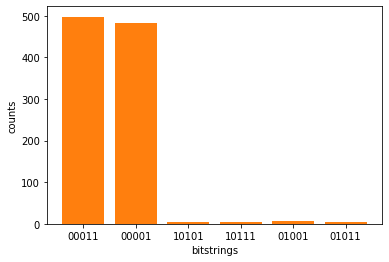

In [81]:
# parse log file for arn
with open(log_file) as f:
    for line in f:
        for part in line.split():
            if "arn:" in part:
                arn = part
                break

# remove final semicolon in logs
arn = arn[:-1]
print(arn)

# with this arn we can restore again task from unique arn
task_load = AwsQuantumTask(arn=arn)

result = task_load.result()
counts = result.measurement_counts

plt.bar(counts.keys(), counts.values(), color="tab:orange")
plt.xlabel("bitstrings")
plt.ylabel("counts")


# Asynchronous execution

When replacing the ```result()``` call on the task object above with ```async_result()```, we can get the quantum task result asynchronously. Consecutive calls to this method return the result cached from the most recent request. See [here](https://github.com/aws/braket-python-sdk/blob/master/src/braket/aws/aws_quantum_task.py#L206) for source code implementation. 

While ```result()``` is a blocking call that waits for the result, ```async_result()``` is a non-blocking call. For example, in Jupyter as shown here, if you run ```result()```, the notebook will stop and wait at this cell for a certain polling time (set as ```poll_timeout_seconds``` with default of 5 days) till the polling returns the result object or times out. If you run ```async_result()```, the notebook immediately goes to the next cell, _not_ waiting for polling to complete. Calling `result()` on the `async_result` object before it has completed, an `asyncio.exceptions.InvalidStateError` will be raised. This is expected behavior. Later, you can call ```result()``` and get the actual result from the task. 

Alternatively, we have provided a basic `asyncio` waiter function `wait_on_result()`, which will create a blocking call, wait for the result, and then return that result for downstream use. We have defaulted the notebook to leverage this call in favor of avoiding the `InvalidStateError`, but we have left the non-blocking `async_result.result()` call example as an option.

In [82]:
# asyncio waiter function to leverage Task.async_result() object
async def wait_on_result(async_result):
    print("Waiting on task.")
    await async_result

    print(f"Final task state: {async_result._state}")
    res = async_result.result()

    return res


In [83]:
# example with async_result - immediately returns asyncio Future object
async_result = device.run(circ, shots=100).async_result()


In [84]:
# async_result.result() then returns the actual result (once completed)
# Non-blocking call. Will raise an InvalidStateError if this is run before async task is complete:
# async_res = async_result.result()
# Blocking call, leveraging asyncio.run and await
async_res = asyncio.run(wait_on_result(async_result))

# get measurement shots
counts = async_res.measurement_counts
print(counts)

Waiting on task.
Final task state: FINISHED
Counter({'00001': 57, '00011': 39, '01001': 2, '10101': 1, '01011': 1})


One can also define custom callbacks to be invoked when the Future is completed. 

In [85]:
# async_result returns back a Future.
# Details on Future: https://docs.python.org/3.8/library/asyncio-future.html#asyncio.Future
future = device.run(circ, shots=100).async_result()

# this is invoked when the Future is done. i.e. task is in a terminal state.
# This will print out to STDOUT when its done.
def call_back_function(future):
    print(f"Custom task Result: {future.result().measurement_probabilities}")


# attached the callback function to the future.
future.add_done_callback(call_back_function)
